# Playing with data with Irena March 30

First, try averaging all chirps

In [13]:
import sys
import sys
sys.path.append("../../xapres/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import pandas as pd
import math

importlib.reload(ApRESDefs)

<module 'ApRESDefs' from '/home/jovyan/xapres_package/notebooks/test_notes/../../xapres_package/ApRESDefs.py'>

In [2]:
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    14:23:49 	 ApRESDefs.py @function _setup_logging line 490 - Stream logging level set to DEBUG
DEBUG    14:23:49 	 ApRESDefs.py @function _setup_logging line 491 - Add console handler to logger
DEBUG    14:23:49 	 ApRESDefs.py @function _setup_logging line 504 - File logging level set to DEBUG


In [3]:
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")


In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34041")
client

<Client: 'tcp://127.0.0.1:34041' processes=4 threads=16, memory=125.81 GiB>

In [8]:
mean_chirp = ds_101.chirp.mean(dim=['time','chirp_num'])

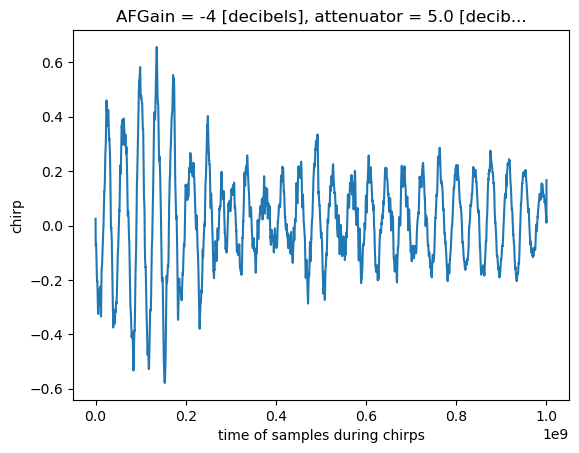

In [10]:
mean_chirp.isel(attenuator_setting_pair=0).plot()

In [21]:
# Define functions with which we can calculate new profiles with
def custom_profile(chirp,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K
    
    chirp = chirp[math.ceil(T0/dt):math.floor(T1/dt)+1]
    win_chirp = (chirp*np.blackman(len(chirp)))
    Nt = len(win_chirp)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros(Nfft)
    padchirp[0:math.floor(Nt/2)] = win_chirp.data[math.floor(Nt/2):-1]
    padchirp[-math.floor(Nt/2):] = win_chirp.data[0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp)/Nfft * math.sqrt(2*pad)
    profile = p[0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(len(profile))])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=2000)
    Range = profile_range[:n]
    Profile = profile_ref[:n]

    return Range, Profile

def custom_profile_stacked(burst,pad=2,F0=2e8,F1=4e8):
    Range,Profile = custom_profile(burst.chirp.isel(chirp_num=0),pad,F0,F1)
    for num in burst.chirp_num.data:
        r_temp,p_temp = custom_profile(burst.chirp.isel(chirp_num=num),pad,F0,F1)
        Profile += p_temp
    Profile = Profile/len(burst.chirp_num.data)
    return Range, Profile

In [22]:
r,p = custom_profile(mean_chirp.isel(attenuator_setting_pair=0))

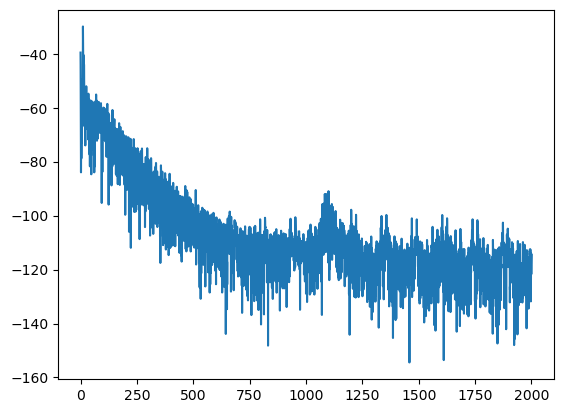

In [23]:
plt.plot(r,xa.dB(p))

Look into testing different center frequencies to calculate profiles from the same chirp

Look into variabilities of thickness and strain rate

To do: look at time series of range diffs for selected ranges - should get a stack of lines. Also look at differencing in vertical direction